# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Logistic Regression

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from skopt import BayesSearchCV

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ChangedBehaviorWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning,
                                          ChangedBehaviorWarning,
                                          DeprecationWarning,
                                          RuntimeWarning))

/home/rei/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Set up directories
SEED = 149028763
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'processed_data', 'features')
dir_out = os.path.join(parent_dir, 'analyses')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)
print('Loaded %i samples with %i features' % X.shape)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y,
                                                    random_state=SEED)

Loaded 105822 samples with 4456 features


## Hyperparameter Tuning

Bayesian search on `LogisticRegression` with `BayesSearchCV`

In [5]:
# Set up classifier pipeline
estimator = LogisticRegression(solver='liblinear', penalty='l1',
                               max_iter=2000, random_state=SEED)

pipe = Pipeline([('scaler', MaxAbsScaler()), ('clf', estimator)])

In [6]:
# Callback function
def status_print(optim_result):
    """Status callback durring Bayesian hyperparameter search"""
    
    # Get current parameters and the best parameters 
    n = len(pd.DataFrame(opt.cv_results_))
    print('Iteration %i, best %s score: %.6f'\
          % (n, scoring, opt.best_score_))

In [7]:
# Perform hyperparameter optimization
param_space = {'clf__C': (1, 5, 'uniform')}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = 'neg_log_loss'

opt = BayesSearchCV(pipe, param_space,cv=cv, scoring=scoring, n_iter=50,
                    n_jobs=5, verbose=0, random_state=SEED)

cv_results = opt.fit(X_train, y_train, callback=status_print)

Iteration 1, best neg_log_loss score: -0.693147
Iteration 2, best neg_log_loss score: -0.256936
Iteration 3, best neg_log_loss score: -0.256926
Iteration 4, best neg_log_loss score: -0.193628
Iteration 5, best neg_log_loss score: -0.178166
Iteration 6, best neg_log_loss score: -0.178166
Iteration 7, best neg_log_loss score: -0.145731
Iteration 8, best neg_log_loss score: -0.145731
Iteration 9, best neg_log_loss score: -0.145731
Iteration 10, best neg_log_loss score: -0.109755
Iteration 11, best neg_log_loss score: -0.109755
Iteration 12, best neg_log_loss score: -0.109755
Iteration 13, best neg_log_loss score: -0.109755
Iteration 14, best neg_log_loss score: -0.109755
Iteration 15, best neg_log_loss score: -0.109755
Iteration 16, best neg_log_loss score: -0.109755
Iteration 17, best neg_log_loss score: -0.109755
Iteration 18, best neg_log_loss score: -0.109755
Iteration 19, best neg_log_loss score: -0.109755
Iteration 20, best neg_log_loss score: -0.109755
Iteration 21, best neg_log_lo

In [8]:
# Set best estimator as classifier
opt.best_params_

print('Test %s score: %.4f' % (scoring, opt.score(X_test, y_test)))
pipe = opt.best_estimator_

{'clf__C': 2.597270846293925}

Test neg_log_loss score: -0.0989


              precision    recall  f1-score   support

           0     0.9782    0.9981    0.9881     19657
           1     0.9666    0.7102    0.8188      1508

    accuracy                         0.9776     21165
   macro avg     0.9724    0.8542    0.9034     21165
weighted avg     0.9774    0.9776    0.9760     21165



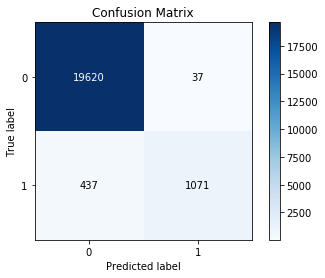

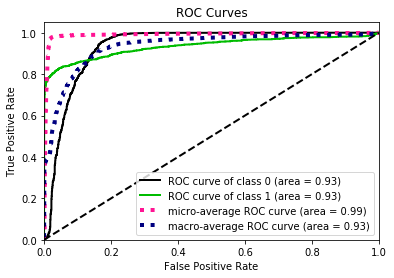

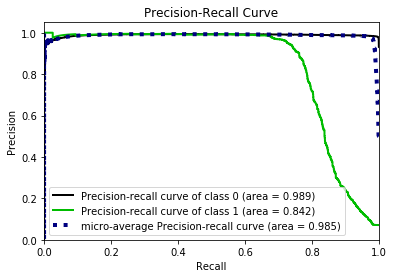

In [9]:
# Evaluate model

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

print(classification_report(y_test, y_pred, digits=4))

# Plot metrics
_ = plot_confusion_matrix(y_test, y_pred)
_ = plot_roc(y_test, y_proba)
_ = plot_precision_recall(y_test, y_proba)
_ = plt.show()

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9747    0.9621    0.9684     36476
           1     0.5728    0.6700    0.6176      2764

    accuracy                         0.9416     39240
   macro avg     0.7738    0.8161    0.7930     39240
weighted avg     0.9464    0.9416    0.9437     39240



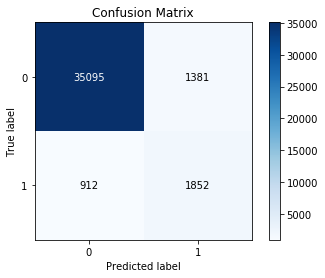

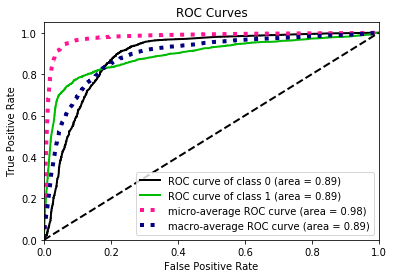

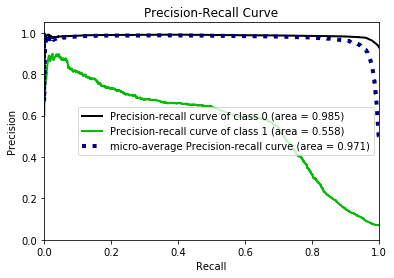

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.9738    0.9748    0.9743     49151
           1     0.6496    0.6409    0.6453      3590

    accuracy                         0.9520     52741
   macro avg     0.8117    0.8078    0.8098     52741
weighted avg     0.9517    0.9520    0.9519     52741



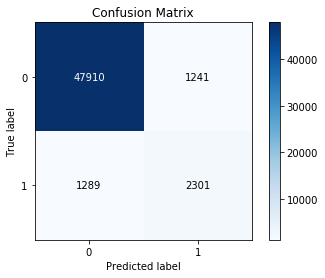

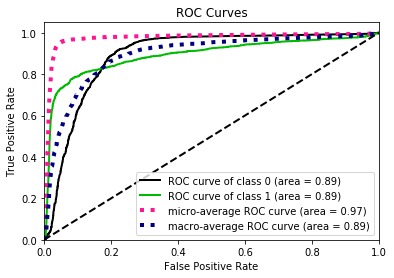

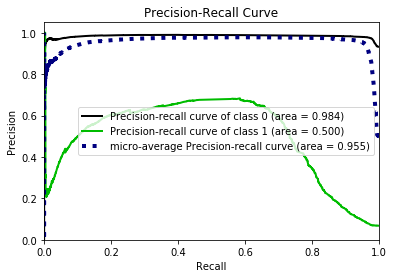

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9762    0.9783    0.9773     12654
           1     0.7636    0.7456    0.7545      1187

    accuracy                         0.9584     13841
   macro avg     0.8699    0.8620    0.8659     13841
weighted avg     0.9580    0.9584    0.9582     13841



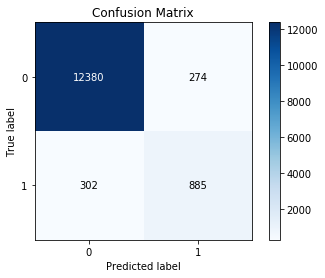

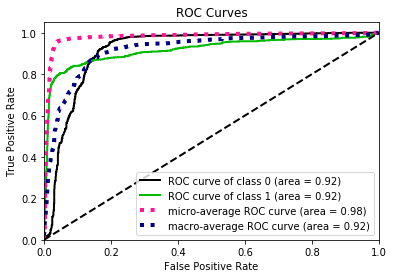

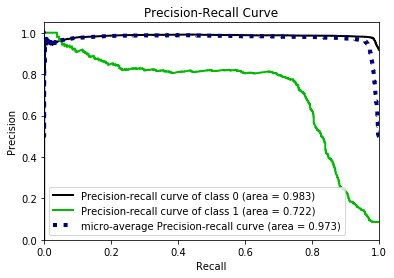

<hr></hr>

In [10]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
%matplotlib inline
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train pipeline
    _ = pipe.fit(X_train, y_train)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plot_precision_recall(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))

In [11]:
# Refit model with the whole dataset
_ = pipe.fit(X, y)

# Dump model as pickle
_ = joblib.dump(pipe, 'best_model.pkl')

## Examine feature importances from coefficients

In [12]:
# Get feature names: Pfam set
feat_names = np.array(joblib.load('pfam.pkl')[1])
feat_names

array(['PF00001', 'PF00002', 'PF00004', ..., 'PF18829', 'PF18837',
       'PF18868'], dtype='<U7')

In [13]:
# Get model coefficients
pipe = joblib.load('best_model.pkl')
coefs = pipe['clf'].coef_[0]

In [14]:
sort_index = coefs.argsort()[::-1] # descending
sorted_coefs = coefs[sort_index]
sorted_feats = feat_names[sort_index]

df = pd.DataFrame([sorted_feats, sorted_coefs], index=['Feature_name', 'Coefficient']).T

In [15]:
# Calculate odds
df['Odds'] = np.exp(df['Coefficient'].astype(float))
df.head(10)
df.tail(10)

,Feature_name,Coefficient,Odds
0,PF07679,55.2947,1.033222e+24
1,PF05473,32.7265,1.632826e+14
2,PF13465,30.9081,2.649873e+13
3,PF13912,28.6026,2.642240e+12
4,PF17820,23.4707,1.560283e+10
5,PF00041,18.9777,1.745546e+08
6,PF13921,18.6526,1.261021e+08
7,PF16620,16.8163,2.010071e+07
8,PF07705,14.6264,2.249988e+06
9,PF00550,14.1184,1.353714e+06


,Feature_name,Coefficient,Odds
4446,PF00578,-13.269,1.727145e-06
4447,PF00102,-13.4886,1.386634e-06
4448,PF04851,-16.8849,4.644747e-08
4449,PF13894,-17.1534,3.551254e-08
4450,PF07686,-17.4608,2.611261e-08
4451,PF00249,-17.9819,1.550837e-08
4452,PF13895,-21.3393,5.401035e-10
4453,PF00096,-25.5666,7.880933e-12
4454,PF00595,-30.8593,3.962379e-14
4455,PF00059,-35.1285,5.545056e-16


In [16]:
# Get unimportant features
unimportant_features = feat_names[coefs==0]
print('Features irrelevant for model: %i features' % len(unimportant_features))
unimportant_features

Features irrelevant for model: 2120 features


array(['PF00018', 'PF00019', 'PF00020', ..., 'PF18829', 'PF18837',
       'PF18868'], dtype='<U7')

<hr></hr>